### Toric and Semitoric Packing Capacities project program

In [ ]:
import numpy as np
from fractions import Fraction
import numpy.linalg as la
from itertools import combinations
from sympy import Point, Polygon 
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as polygon



def checkConvex(vertices):
  polygon = Polygon(*map(Point, vertices))
  return polygon.is_convex()


#version 1 (work but optimization needed)
def scale(vertices):
  demoni = np.array([], dtype = int) #array for all denominator in Fraction form of corridinates
  nomi = np.array([], dtype=int) #arr for all nominator of corridiate after removing Fraction form
  for vertice in vertices: #add all denominator in the demoni np array
    for cor in vertice:
      cor = Fraction(cor)
      demoni = np.append(demoni, int(cor.denominator))
      
  lcm = np.lcm.reduce(demoni) #calculate the lcm for all demoni

  for vertice in vertices: #multiply corridinate with lcm to remove the Fraction form
    vertice *= lcm
  vertices = vertices.astype(int)
  for i in range(len(vertices)): # use floor division to convert 
    for j in range(len(vertices[i])):
      vertices[i][j] = int(vertices[i][j]) // 1

  return vertices

#To do: figure out how to show image with in a function (may save in local first and display at the end of program)
def show_graph(Vertices, sl2_length, first, tittle=""): 
  Vertices = Vertices.tolist()
  Vertices.append(Vertices[0]) #repeat the first point to create a 'closed loop'
  xs, ys = zip(*Vertices) #create lists of x and y values

  #first = max_list[0]
  for i in range(len(first)):
    if (first[i] != 0):
      packing = [Vertices[i]]

      forward = i + 1 if i + 1 < len(first) else 0
      backward = i - 1 if i - 1 >= 0 else len(first) - 1
      
      forward_vertex = np.array(Vertices[i]) + (first[i] / sl2_length[i]) * np.array([Vertices[forward][0] - Vertices[i][0], Vertices[forward][1] - Vertices[i][1]])
      backward_vertex = np.array(Vertices[i]) + (first[i] / sl2_length[backward]) * np.array([Vertices[backward][0] - Vertices[i][0], Vertices[backward][1] - Vertices[i][1]])
      packing.append(forward_vertex)
      packing.append(backward_vertex)
      axes = plt.gca()
      axes.add_patch(polygon(packing, closed=True, facecolor='orange'))

  #     print("value of i: {}\n forward:{}\n backward:{}\n packing vertices: {}".format(i, forward, backward, packing))
  #     print("forward vertices: {}".format(forward_vertex))
  #     print("backward vertices: {}\n".format(backward_vertex))
  # print("Vertices: {}\nsl2: {}\n".format(Vertices, sl2_length))
  plt.axis("equal")
  plt.plot(xs,ys) 
  plt.title(tittle)
  plt.show()



#Delzan Section
#This function verifies the Delzant determinant condition for two edges (three vertices), returning true if the condition is met and false otherwise
def verifyDelzant(vert, nA, nB):
  # This breaks if vert == nA or vert == nB as gcd will output zero.
  # we can check for this, but it may be a waste of time

  # compute the edges to compair
  edgeA = nA - vert
  edgeB = vert - nB

  # find the primitive direction vector of the edges
  a = np.gcd(edgeA[0], edgeA[1])
  edgeA = edgeA / a

  b = np.gcd(edgeB[0], edgeB[1])
  edgeB = edgeB / b

  # find the determinant 
  return abs((edgeA[0] * edgeB[1]) - (edgeB[0] * edgeA[1])) == 1

#This function will comput the  SL2(ℤ)  lengths of any two vertices of integer coordinates
def getSL(vert, nVert):
# Again, this code breaks if vert == nVert,
# but this may not be worth checking
# If vert is the origin
  if not np.any(vert):
    return np.gcd(nVert[0], nVert[1])
  # If nVert is the origin
  elif not np.any(nVert):
    return np.gcd(vert[0], vert[1])
  # Otherwise
  else:
    return np.gcd(nVert[0] - vert[0] , nVert[1] - vert[1])


#This function will take in an array of vertices, create a temporary edge, and send that edge to a function that will verify it's Delzant proproties and another that will obtain the  SL2(ℤ)  length, returning a numpy array of these lengths
def get_edges(vertices):
  len = np.int(vertices.size / 2)
  sl2ZLengths = np.zeros(len)
  for i in range(len):
    vert = vertices[i]
    if i + 1 >= len:
      nA = vertices[0]
      nB = vertices[i - 1]
    elif i - 1 < 0:
      nA = vertices[i + 1]
      nB = vertices[i - 1] # this conditional is the same as the next one, don't we want [n-1] instead of [i-1] ??
    else:
      nA = vertices[i + 1]
      nB = vertices[i - 1]
    if (not verifyDelzant(vert, nA, nB)):
      return False, sl2ZLengths
    else:
      sl2ZLengths[i] = getSL(vert, nA)
  
  return True, sl2ZLengths
    


#SL_length is the array contains the SL2 length
#ieq_idx contains the information for inequality. 2d array, each row represent one inequality
#ie: [i,j,idx] lamda_i + lamda_j ≤ SL2_idx 
# k is the number of equalities we take each time to compute candidate
def get_candidate(SL_length, k):
  result = set()
  n = len(SL_length)
  #print("value of n: {}".format(n))
  lamdas = list(combinations([i for i in range(n)], k))
  zeros = list(combinations([i for i in range(n)], n-k))
  for possible in lamdas:
    row_idx = 0
    A = np.zeros((n,n))
    b = np.zeros(n)
    for i in possible:
      idx1 = i
      idx2 = i + 1 if (i+1) < (n) else 0
      #print("value of idx123: {} {} {}".format(idx1, idx2, idx1))
      A[row_idx][idx1] = 1.0
      A[row_idx][idx2] = 1.0
      b[row_idx] = SL_length[idx1]
      row_idx += 1

    if (len(zeros) != 0):
      for poss in zeros:
        z_idx = row_idx
        AA = A.copy()
        for z in poss:
          AA[z_idx][z] = 1
          z_idx += 1
        
        candidate = np.zeros_like(b)
        candidate[0] = -10;
        try:
          candidate = la.solve(AA,b)
        except:
          pass
        if (np.any(candidate < 0)):
          pass
        else:
          result.add(tuple(np.abs(candidate)))
  return result

#wrap function for all possibilities for once
def get_vertex(SL_length):
  final = list()
  final.append(tuple(np.zeros(len(SL_length))))
  for i in range(1, len(SL_length) + 1):
    tmp = get_candidate(SL_length, i)
    for t in tmp:
      if t not in final:
        final.append(t)
  
  return sorted(final, key=magnitude,reverse=True)

def magnitude(Vertex):
  sum = 0
  for v in Vertex:
    sum += v**2
  sum /= 2
  return sum

def filter(vertex, SL2):
  for i in range(len(vertex)):
    later = i + 1 if (i+1) < len(vertex) else 0
    if ((vertex[i]+vertex[later]) > SL2[i]):
      return False;
  return True;


def parse(SL2_lengths):
  candidate = get_vertex(SL2_lengths)
  num = 1
  tmp = []
  result = []
  for i in candidate:
    if(filter(i, SL2_lengths)):
      print("{}th:\t Vertex Coordinate: {}\t Magnitude: {}".format(num, i, magnitude(i)))
      num += 1
      tmp.append(i)

  maximum = magnitude(tmp[0])
  for i in tmp:
    if (magnitude(i) == maximum):
      result.append(i)
  
  return result

def show_info(Vertices):
  if (not checkConvex(Vertices)):
    print("Convex Polygon, Please check your input vertices")
    return;

  Vertices = scale(Vertices);
  # show_graph(Vertices)
  print("The 2D graph of polygon shows above\n")
  valid, sl2_length = get_edges(Vertices)
  if (not valid):
    print("Not Delzant, Please check your input vertices")
    return;

  print("This is the array of SL2 length: \n{} \n\nFollowing shows the Packing vertices & its magnitude: ".format(sl2_length))
  Coordinates = parse(sl2_length)
  for i in Coordinates:
    show_graph(Vertices,sl2_length, i)


#Data structure: 
Vertices: size of np array (x,y)
x,y are objects of fraction module. eg:x = fraction(a,b) = a/b

Array of vertex: 2d np array containg the per vertice per row

[[x,y],

[x,y]]

Input requirement: Counterclock wise vertices order

The 2D graph of polygon shows above

This is the array of SL2 length: 
[13. 17.  1.  2.  8.  7.] 

Following shows the Packing vertices & its magnitude: 
1th:	 Vertex Coordinate: (0.0, 13.0, 1.0, 0.0, 1.0, 7.0)	 Magnitude: 110.0
2th:	 Vertex Coordinate: (0.0, 13.0, 0.0, 1.0, 1.0, 7.0)	 Magnitude: 110.0
3th:	 Vertex Coordinate: (0.0, 13.0, 1.0, 0.0, 0.0, 7.0)	 Magnitude: 109.5
4th:	 Vertex Coordinate: (0.0, 13.0, 0.0, 1.0, 0.0, 7.0)	 Magnitude: 109.5
5th:	 Vertex Coordinate: (0.0, 13.0, 0.0, 0.0, 1.0, 7.0)	 Magnitude: 109.5
6th:	 Vertex Coordinate: (0.0, 13.0, 0.0, 0.0, 0.0, 7.0)	 Magnitude: 109.0
7th:	 Vertex Coordinate: (0.0, 13.0, 1.0, 0.0, 2.0, 6.0)	 Magnitude: 105.0
8th:	 Vertex Coordinate: (0.0, 13.0, 0.0, 0.0, 2.0, 6.0)	 Magnitude: 104.5
9th:	 Vertex Coordinate: (1.0, 12.0, 1.0, 0.0, 2.0, 6.0)	 Magnitude: 93.0
10th:	 Vertex Coordinate: (1.0, 12.0, 0.0, 0.0, 2.0, 6.0)	 Magnitude: 92.5
11th:	 Vertex Coordinate: (0.0, 13.0, 1.0, 0.0, 2.0, 0.0)	 Magnitude: 87.0
12th:	 Vertex Coordina

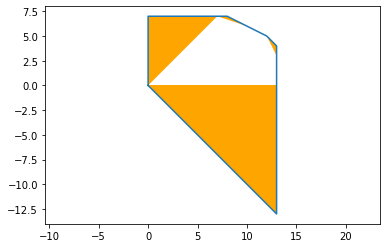

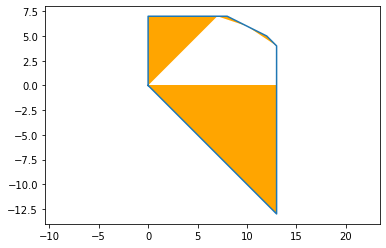

In [ ]:
test = np.array([[0,0],
                 [13,-13],
                 [13,4],
                 [12,5],
                 [8,7],
                 [0,7]
                 ]
                     )
show_info(test)

The 2D graph of polygon shows above

This is the array of SL2 length: 
[6. 1. 3. 1.] 

Following shows the Packing vertices & its magnitude: 
1th:	 Vertex Coordinate: (1.0, 0.0, 1.0, 0.0)	 Magnitude: 1.0
2th:	 Vertex Coordinate: (1.0, 1.0, 0.0, 0.0)	 Magnitude: 1.0
3th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 1.0)	 Magnitude: 1.0
4th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 1.0)	 Magnitude: 1.0
5th:	 Vertex Coordinate: (1.0, 0.0, 0.0, 0.0)	 Magnitude: 0.5
6th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 1.0)	 Magnitude: 0.5
7th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 0.0)	 Magnitude: 0.5
8th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 0.0)	 Magnitude: 0.5
9th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 0.0)	 Magnitude: 0.0


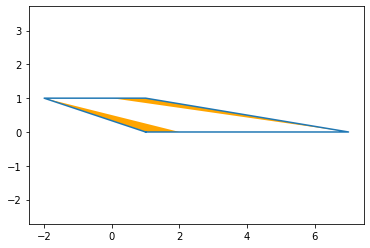

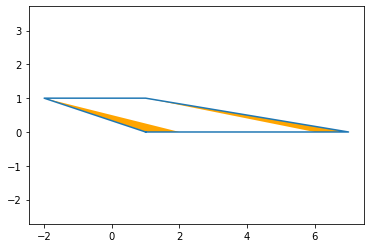

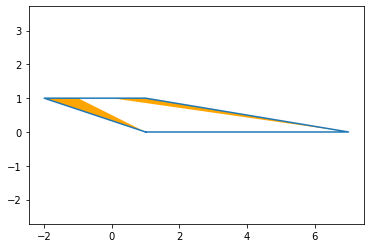

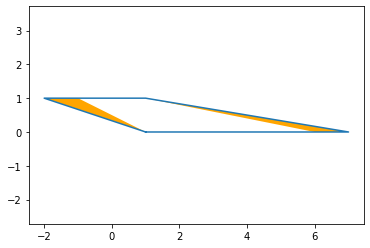

In [ ]:
test = np.array([[1,0],
                     [7,0],
                 [1,1],
                     [-2,1]]
                  
                     )
show_info(test)

#test field

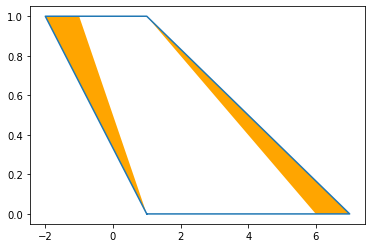

In [ ]:
test = np.array([[1,0],
                     [7,0],
                 [1,1],
                     [-2,1]]
                     )
max_list = [
            (1.0, 0.0, 1.0, 0.0),
            (1.0, 1.0, 0.0, 0.0),
            (0.0, 0.0, 1.0, 1.0),
            (0.0, 1.0, 0.0, 1.0)
]
sl2_length = [6.0, 1.0, 3.0, 1.0] 

def show_graph2(Vertices, sl2_length, max_list, tittle=""): 
  Vertices = Vertices.tolist()
  Vertices.append(Vertices[0]) #repeat the first point to create a 'closed loop'
  xs, ys = zip(*Vertices) #create lists of x and y values

  first = max_list[3]
  for i in range(len(first)):
    if (first[i] != 0):
      packing = [Vertices[i]]

      forward = i + 1 if i + 1 < len(first) else 0
      backward = i - 1 if i - 1 >= 0 else len(first) - 1
      
      forward_vertex = np.array(Vertices[i]) + (first[i] / sl2_length[i]) * np.array([Vertices[forward][0] - Vertices[i][0], Vertices[forward][1] - Vertices[i][1]])
      backward_vertex = np.array(Vertices[i]) + (first[i] / sl2_length[backward]) * np.array([Vertices[backward][0] - Vertices[i][0], Vertices[backward][1] - Vertices[i][1]])
      packing.append(forward_vertex)
      packing.append(backward_vertex)
      axes = plt.gca()
      axes.add_patch(polygon(packing, closed=True, facecolor='orange'))

  #     print("value of i: {}\n forward:{}\n backward:{}\n packing vertices: {}".format(i, forward, backward, packing))
  #     print("forward vertices: {}".format(forward_vertex))
  #     print("backward vertices: {}\n".format(backward_vertex))
  # print("Vertices: {}\nsl2: {}\n".format(Vertices, sl2_length))

  plt.plot(xs,ys) 
  plt.title(tittle)
  plt.show()

show_graph2(test,sl2_length, max_list)


[[4 3]
 [4 0]
 [1 0]
 [0 1]
 [0 3]]
[[ 3  2]
 [ 3 -1]
 [ 0 -1]
 [-1  0]
 [-1  2]]


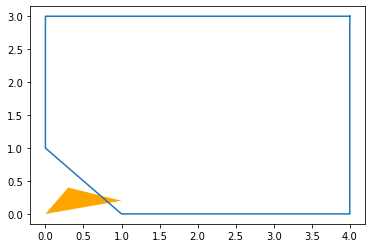

In [ ]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt

def show_graph2(Vertices, tittle=""): 
  print(Vertices)
  print(Vertices-1)
  Vertices1 = Vertices.tolist()
  Vertices1.append(Vertices1[0]) #repeat the first point to create a 'closed loop'
  xs, ys = zip(*Vertices1) #create lists of x and y values  

  axes = plt.gca()
  axes.add_patch(Polygon([(0, 0), (1, 0.2), (0.3, 0.4)], closed=True, facecolor='orange'))

  plt.plot(xs,ys) 
  plt.title(tittle)
  plt.show()


show_graph2(vertices)


The 2D graph of polygon shows above

This is the array of SL2 length: 
[4. 1. 3. 1.] 

Following shows the Packing vertices & its magnitude: 
1th:	 Vertex Coordinate: (1.0, 0.0, 1.0, 0.0)	 Magnitude: 1.0
2th:	 Vertex Coordinate: (1.0, 1.0, 0.0, 0.0)	 Magnitude: 1.0
3th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 1.0)	 Magnitude: 1.0
4th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 1.0)	 Magnitude: 1.0
5th:	 Vertex Coordinate: (1.0, 0.0, 0.0, 0.0)	 Magnitude: 0.5
6th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 1.0)	 Magnitude: 0.5
7th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 0.0)	 Magnitude: 0.5
8th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 0.0)	 Magnitude: 0.5
9th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 0.0)	 Magnitude: 0.0


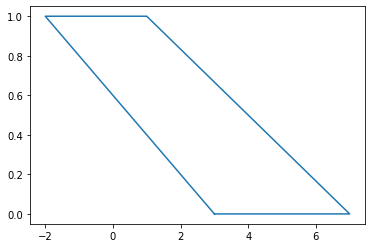

In [ ]:
test = np.array([[Fraction('3'),0],
                     [7,0],
                 [1,1],
                     [-2,1]]
                     )
show_info(test)

In [ ]:
# SIMPLE TESTCASES For Verify Delzant
vert = np.array([2,1])
nA = np.array([7,0])
nB = np.array([1,1])

print(verifyDelzant(vert, nA, nB) == True)

True


In [ ]:
# SIMPLE TEST CASE For getSL

vert = np.array([2,1])
nVert = np.array([4,0])
getSL(vert, nVert)

1

In [ ]:

# TEST CASES For get_edges

# THIRD MINIMAL POLYGON
thid_min = np.array([[0,0],
                     [7,0],
                     [2,1],
                     [1,1]])

result = np.array([7, 1, 1, 1])
#print(np.all(get_edges(thid_min) == result))

parse(result)

In [ ]:
testsl = np.array([1,10,10,1,10,10])
ineq = np.array([[1,2,1],
                 [2,3,2],
                 [3,4,3],
                 [4,5,4],
                 [5,6,5],
                 [1,6,6],
                 ])

result = get_vertex(testsl)
num = 1
for i in result:
   if (filter(i, testsl)):
     print("{}th:\t Vertex Coordinate: {}\t sum value: {}".format(num, i, magnitude(i)))
     num += 1;

In [ ]:
testsl = np.array([1,2,2,2,3])

result = get_vertex(testsl)
num = 1
for i in result:
   if (filter(i,testsl)):
     print("{}th:\t Vertex Coordinate: {}\t sum value: {}".format(num, i, magnitude(i)))
     num += 1;
# for i in result:
#   print(i)
# for i in result:
#      print("{}th:\t Vertex Coordinate: {}\t sum value: {} \t bool:{}".format(num, i, magnitude(i),filter(i, ineq,testsl)))
#      num += 1;

In [ ]:
testsl = np.array([1,2,3,4])
ineq = np.array([[0,1,0],
                 [1,2,1],
                 [2,3,0],
                 [0,3,2]
                 ])

result = get_vertex(testsl)
for i in result:
  print(i)


In [ ]:
testsl = np.array([1,2,3,4])
ineq = np.array([[1,2,0],
                 [2,3,1],
                 [3,4,0],
                 [1,4,2]
                 ])

result = get_vertex(testsl)
for i in result:
  print(i)


In [ ]:
# test below:
vertices = np.array([[Fraction('0.85'), Fraction('0.3')],
                    [Fraction('1/3'), Fraction('0')],
                     
                    [Fraction('0.5'), Fraction('0.5')]])

print(vertices)
result = scale(vertices)
print(result)


In [ ]:
def scale2(vertices):
  demoni = np.array([], dtype = int) #array for all denominator in Fraction form of corridinates
  nomi = np.array([], dtype=int) #arr for all nominator of corridiate after removing Fraction form
  for vertice in vertices: #add all denominator in the demoni np array
    print("Value of vertice is: {}".format(vertice))
    for cor in vertice:
      cor = Fraction(cor)
      demoni = np.append(demoni, int(cor.denominator))
      
  lcm = np.lcm.reduce(demoni) #calculate the lcm for all demoni

  for vertice in vertices: #multiply corridinate with lcm to remove the Fraction form
    vertice *= lcm

  for i in range(len(vertices)): # use floor division to convert 
    for j in range(len(vertices[i])):
      vertices[i][j] = vertices[i][j] // 1
  return vertices


#Test of show graph
vertices = np.array([  
                   [4, 3],
                   [4, 0],
                   [1, 0],
                   [0, 1],
                   [0, 3],
                   ])
vertices = scale2(vertices)
print(vertices)

Value of vertice is: [4 3]
Value of vertice is: [4 0]
Value of vertice is: [1 0]
Value of vertice is: [0 1]
Value of vertice is: [0 3]
[[4 3]
 [4 0]
 [1 0]
 [0 1]
 [0 3]]


[[4 3]
 [4 0]
 [1 0]
 [0 1]
 [0 3]]
[[ 3  2]
 [ 3 -1]
 [ 0 -1]
 [-1  0]
 [-1  2]]


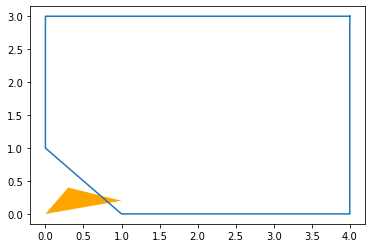

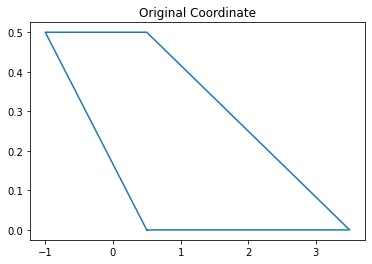

The 2D graph of polygon shows above

This is the array of SL2 length: 
[6. 1. 3. 1.] 

Following shows the Packing vertices & its magnitude: 
1th:	 Vertex Coordinate: (1.0, 0.0, 1.0, 0.0)	 Magnitude: 1.0
2th:	 Vertex Coordinate: (1.0, 1.0, 0.0, 0.0)	 Magnitude: 1.0
3th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 1.0)	 Magnitude: 1.0
4th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 1.0)	 Magnitude: 1.0
5th:	 Vertex Coordinate: (1.0, 0.0, 0.0, 0.0)	 Magnitude: 0.5
6th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 1.0)	 Magnitude: 0.5
7th:	 Vertex Coordinate: (0.0, 0.0, 1.0, 0.0)	 Magnitude: 0.5
8th:	 Vertex Coordinate: (0.0, 1.0, 0.0, 0.0)	 Magnitude: 0.5
9th:	 Vertex Coordinate: (0.0, 0.0, 0.0, 0.0)	 Magnitude: 0.0


In [ ]:
test = np.array([[0.5,0],
                     [3.5,0],
                 [0.5,0.5],
                     [-1,0.5]]
                     )
show_info(test)

[[4 3]
 [4 0]
 [1 0]
 [0 1]
 [0 3]]
<class 'matplotlib.path.Path'>


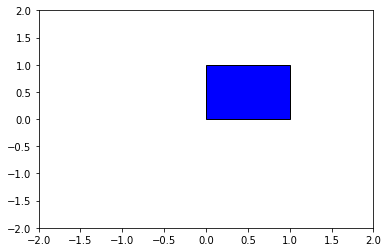

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

vertices = np.array([  
                   [4, 3],
                   [4, 0],
                   [1, 0],
                   [0, 1],
                   [0, 3],
                   ])
print(vertices)
verts = [
   (0., 0.),  # left, bottom
   (0., 1.),  # left, top
   (1., 1.),  # right, top
   (1., 0.),  # right, bottom
   (0., 0.),  # ignored
]
codes = [
    Path.MOVETO,
    Path.LINETO,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY,
]

path = Path(verts, codes)
print(Path)
fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='blue', lw=1)
ax.add_patch(patch)


ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()